# Significance

## Site-specific examples

Take single grid cells, for this example ones containing Maseru, Maputo, Pretoria, and Balawayo, and compare values from El Niño periods against those from other, randomly selected, time slices from the respective regions. 

### Set environment

In [1]:
#--- Libraries
import matplotlib.pyplot as plt      # plotting package
import seaborn as sns                # plotting aestetics
import netCDF4 as nc                 # package to read NetCDF files
import pandas as pd                  # packages for statistics
import numpy as np                   # packages for linear algebra

plt.xkcd()
%matplotlib inline

In [2]:
#--- Set city coordinates
# approximate values
locations = {'Bulawayo' : (-20.2,28.5),
             'Petoria'  : (-25.8,28.3),
             'Maputo'   : (-25.8,32.6),
             'Maseru'   : (-29.3,27.6)}

In [3]:
#--- Load data
# precip anomalies
ncfile_anom = nc.Dataset('data/precip.mon.mean.safr.anom.nc')
# El Nino dates
mei_elnino_dates = pd.read_pickle('data/mei_elnino_dates.pkl')

In [4]:
#--- Set dates
# netcdf file labels dates as days since 1800-01-01
base_date = pd.datetime(1800,1,1)
# determine dates based on incriment from base date
timestamps = [base_date + pd.datetools.timedelta(date) for date in ncfile_anom.variables['time'][:]]
# set as date time index
timestamps = pd.to_datetime(timestamps)

# only consider El Nino dates in range of precipitation estimate
mei_elnino_dates = mei_elnino_dates[mei_elnino_dates > '1978']
mei_elnino_dates = mei_elnino_dates[mei_elnino_dates < '2015-10-01']

In [5]:
# =============================================================
# ** function to read grid cell containing selected coordinates 
# *  read in lat/lon coords.
# *  output a data frame 
def extract_loc(lat,lon) :
    # find site that best matches location of station
    lon_diffs = np.abs(ncfile_anom.variables['lon'][:] - lon)
    nearest_lon = float(ncfile_anom.variables['lon'][np.min(lon_diffs) == lon_diffs])
    lat_diffs = np.abs(ncfile_anom.variables['lat'][:] - lat)
    nearest_lat = float(ncfile_anom.variables['lat'][np.min(lat_diffs) == lat_diffs])
    # find element location
    ind_lon = list(ncfile_anom.variables['lon'][:]).index(nearest_lon)
    ind_lat = list(ncfile_anom.variables['lat'][:]).index(nearest_lat)  
    # pull data 
    cell = pd.Series(ncfile_anom.variables['precip'][:,ind_lat,ind_lon],
                     index=timestamps)
    return cell

# =============================================================

In [6]:
#--- Set data
# create table to hold data
precip_anom = pd.DataFrame(columns=locations.keys())
# loop over locations
for loc in locations.keys() :
    # extract time series at location
    precip_anom[loc] = extract_loc(locations[loc][0],locations[loc][1])


### Bootstrap estimates

Now want to compare statistics for these locations during El Niño periods against those of a random selection of an equal number of time-slices. Each collection of 75 random draws is referred to as a sample.

In [7]:
#--- Generate data for bootstraping estimates
# set number of samples
nsamps = 1000
# create sample labels
names = ['El Nino']
names.extend(['sample %01d' % (x+1) for x in range(nsamps)])
# create panel to hold data
bootstrap = pd.Panel(items=locations.keys(),major_axis=range(len(mei_elnino_dates)),minor_axis=names)
# loop over all location
for loc in locations.keys() :
    # read in El Niño values 
    bootstrap[loc]['El Nino'] = np.array(precip_anom[loc][mei_elnino_dates])
    # loop over number of samples 
    for i in range(1,nsamps+1) :
        # draw same number of values as in El Niño period
        draws = np.random.choice(precip_anom[loc],size=len(mei_elnino_dates),replace=True)
        # store results
        bootstrap[loc]['sample %01d' % i] = draws
        

Here, create an image showing the all the draws that compose each individual sample, to show how the mean value sits within the full range of the values within a sample. 

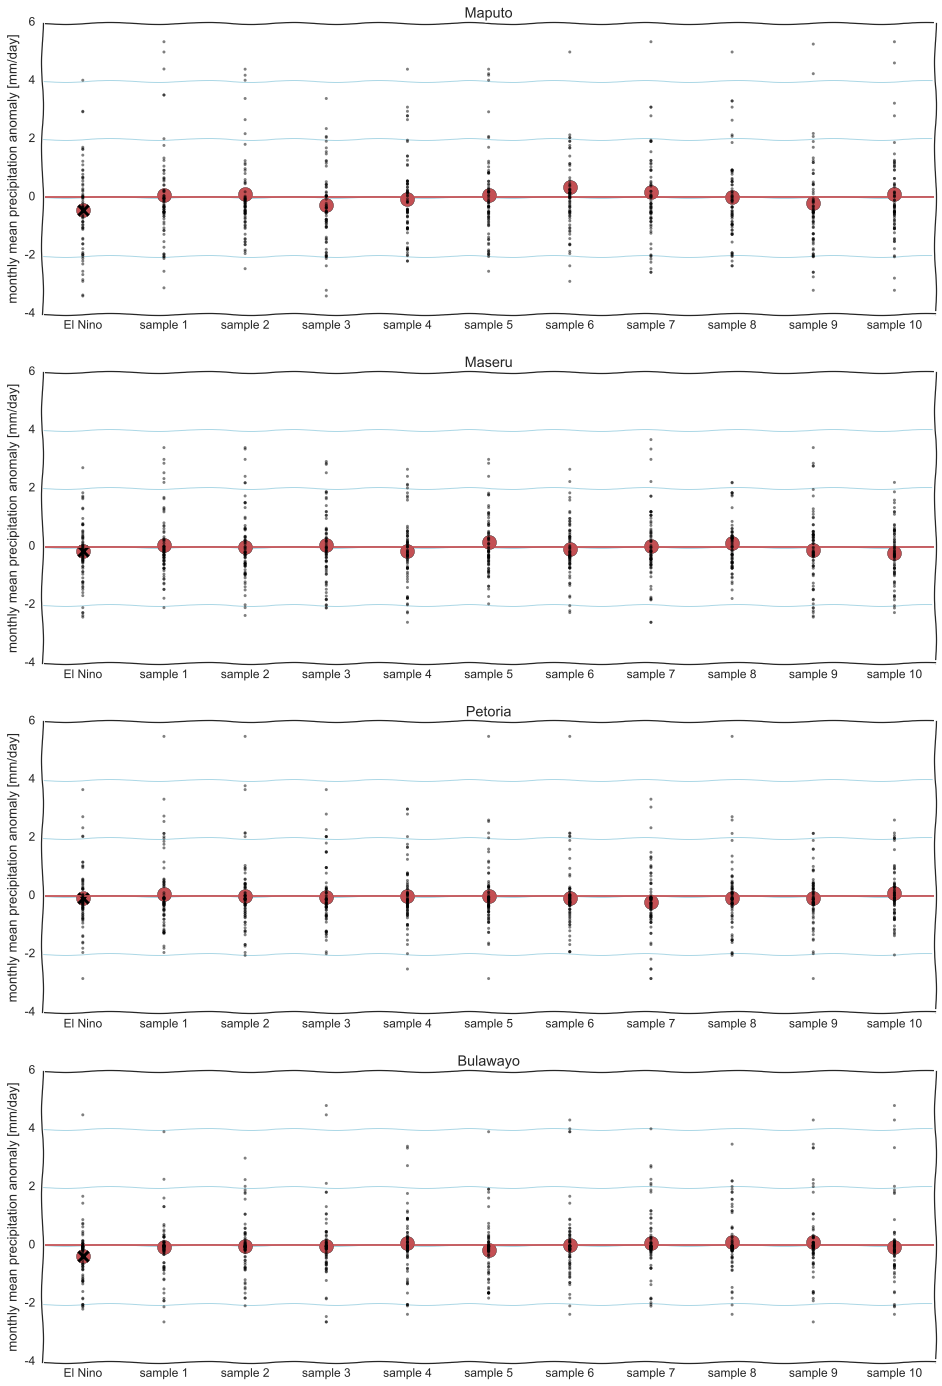

In [10]:
#--- Show examples with limited number of random samples
# create figure
fig, chart = plt.subplots(4,figsize=(16,24))
# increase font size
sns.set(font_scale=1.2)
# choose color map
sns.set_palette('deep')
# list colors in palette
cp = sns.color_palette('deep')
# start counter
c = 0
# loop over all location
for loc in locations.keys() :
    # choose background
    sns.set_style('white')
    # show all draws for each sample
    sns.stripplot(x='variable',y='value',data=pd.melt(bootstrap[loc].iloc[:,0:11]),
                  ax=chart[c],alpha=0.5,color='black',s=3)
    # highlight zero-level
    chart[c].hlines(y=0,xmin=-10,xmax=50,color=cp[2])
    # mark horizontal levels
    _ = chart[c].yaxis.grid(True,linewidth=1,color='lightblue')
    # set axis limits
    _ = chart[c].set_ylim(-4,6)
    # calculate the mean for each sample
    sample_means = bootstrap[loc].mean() 
    # show sample means
    chart[c].scatter(range(11),sample_means[:11],s=200,c=cp[2],alpha=.99,marker='o')
    # highlight sample mean of El Niño collection
    chart[c].scatter(0,sample_means[0],c='black',s=100,marker='x',linewidths=3)
    # label axis
    chart[c].set_ylabel('monthly mean precipitation anomaly [mm/day]')
    chart[c].set_xlabel('')
    # label region
    chart[c].set_title(loc)
    # iterate counter
    c += 1

plt.savefig('example_distributions.png')

Now, showing just the mean values, but for all of the samples. Want to see if the mean value of the El Niño events sits within the 'typical' range of values created by drawing at random from the full data set. 

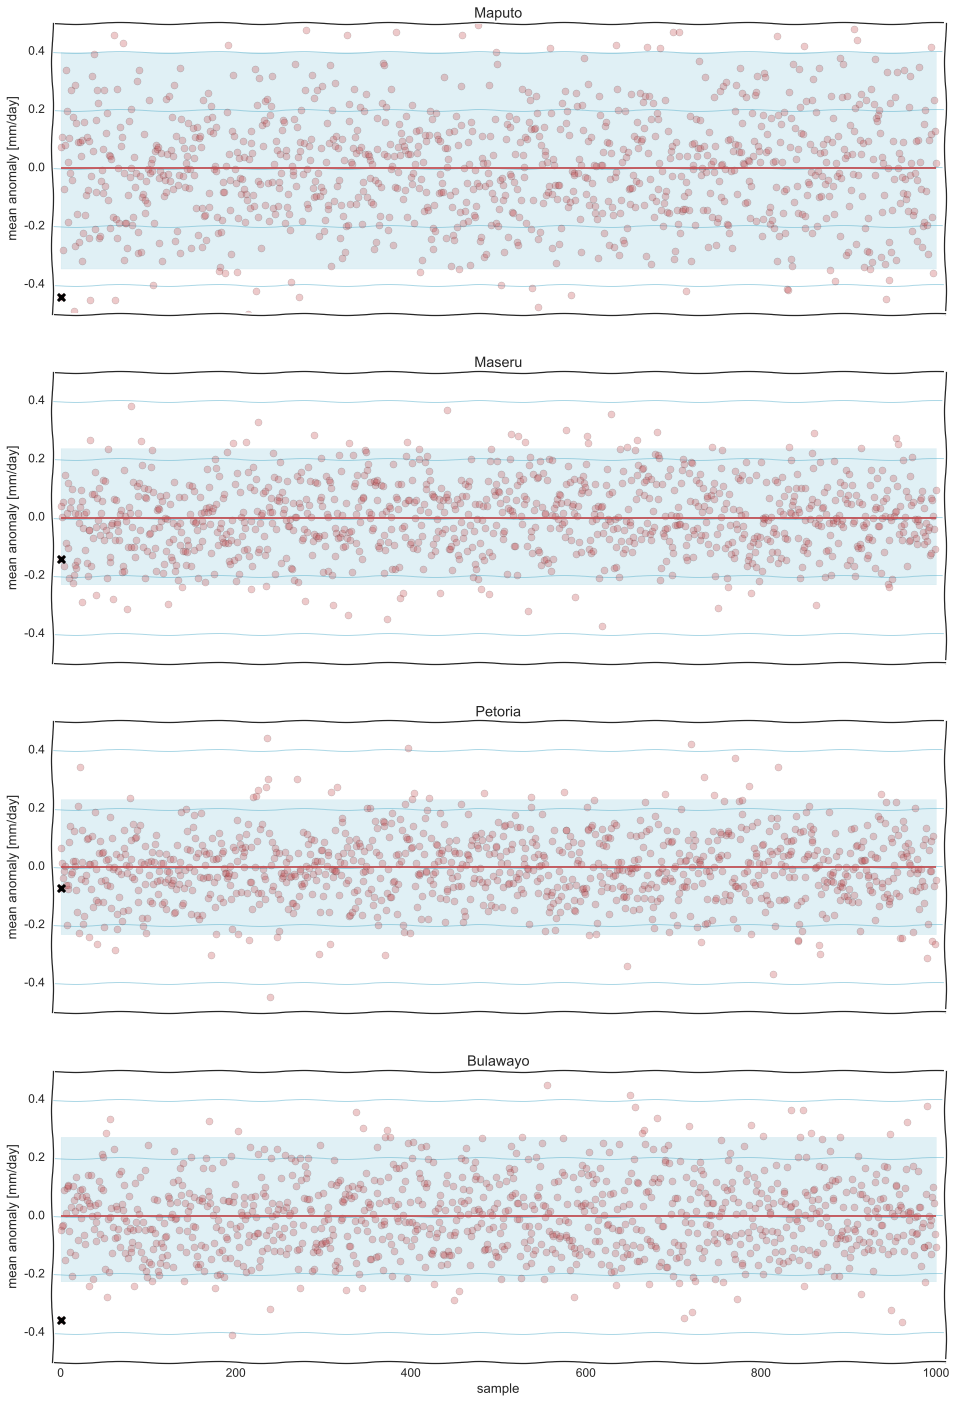

In [9]:
#--- Show range of sample means
# create figure
fig, chart = plt.subplots(4,figsize=(16,24),sharex=True)
# increase font size
sns.set(font_scale=1.2)
# choose color map
sns.set_palette('deep')
# list colors in palette
cp = sns.color_palette('deep')
# start counter
c = 0
# loop over all location
for loc in locations.keys() :
    # choose background
    sns.set_style('white')
    # calculate the mean for each sample
    sample_means = bootstrap[loc].mean()
    # highlight 95% density area
    _ = chart[c].fill_between(range(len(sample_means)),
                              np.repeat(np.float(sample_means[1:].quantile([0.975])),len(sample_means)),
                              np.repeat(np.float(sample_means[1:].quantile([0.025])),len(sample_means)),
                              alpha=0.2,color=cp[5])

    # show sample means
    _ = chart[c].scatter(range(len(sample_means)),sample_means,c=cp[2],s=50,alpha=0.3)
    # highlight mean of El Niño sample 
    _ = chart[c].scatter(0,sample_means[0],c='black',s=50,marker='x',linewidths=3)
    # highlight zero-level
    chart[c].hlines(y=0,xmin=0,xmax=1000,color=cp[2])
    # mark horizontal levels
    _ = chart[c].yaxis.grid(True,linewidth=1,color='lightblue')
    # set axis limits
    _ = chart[c].set_ylim(-0.5,0.5)
    _ = chart[c].set_xlim(-10,1010)
    # label axis
    _ = chart[c].set_ylabel('mean anomaly [mm/day]')
    if (c==3) :
        _ = chart[c].set_xlabel('sample')
    # label region
    _ = chart[c].set_title(loc)
    # iterate counter
    c += 1
    
plt.savefig('bootstrap_distributions.png')